In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [42]:
dataset_path = "./data/sentiment_analysis.csv"

df = pd.read_csv(dataset_path, index_col="id")

df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [43]:
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [44]:
# def text_normalize(text):
#     tokens = tokenizer.tokenize(text)
#     text_tokens = []
#     for token in tokens:
#         if token in stop_words:
#             continue
#         if re.fullmatch(r"[a-z]+", token):
#             text_tokens.append(token)
#     return text_tokens
def text_normalize(text):
    """
    Chuẩn hóa văn bản theo yêu cầu: Bỏ RT, liên kết, dấu #, tokenization, chữ thường, bỏ mention.
    """
    # 1. Bỏ "RT" (Retweet) và chuyển thành chữ thường (đã có trong TweetTokenizer)
    text = text.replace("rt", "").strip()

    # 2. Bỏ Liên kết (URL)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # 3. Tokenize
    tokens = tokenizer.tokenize(text)

    normalized_tokens = []
    for token in tokens:
        # 4. Bỏ dấu # (Chỉ giữ lại từ chính của hashtag)
        if token.startswith("#"):
            token = token[1:]  # Loại bỏ ký tự '#'

        # 5. Bỏ dấu câu và chỉ giữ lại từ
        # Loại bỏ các token không phải chữ cái và Stopwords
        if re.fullmatch(r"[a-z]+", token) and token not in stop_words:
            normalized_tokens.append(token)

    return normalized_tokens

In [45]:
# text = """We love this! Would you go?
# #talk #makememories #unplug
#  #relax #iphone #smartphone #wifi #connect...
# http://fb.me/6N3LsUpCu
# """
# text = text_normalize(text)
# text

In [46]:
# tính toán tần suất (frequency) của các từ (tokens) trong toàn bộ tập dữ liệu
def get_freqs(df):
    freqs = defaultdict(int)

    for row in df.itertuples():
        label = row.label
        tokens = row.tokens

        for word in tokens:
            freqs[(word, label)] += 1
    return freqs


df["tokens"] = df["tweet"].apply(text_normalize)
freqs = get_freqs(df)

freqs

defaultdict(int,
            {('fingerprint', 0): 4,
             ('pregnancy', 0): 1,
             ('test', 0): 9,
             ('android', 0): 361,
             ('apps', 0): 124,
             ('beautiful', 0): 236,
             ('cute', 0): 328,
             ('health', 0): 117,
             ('igers', 0): 145,
             ('iphoneonly', 0): 133,
             ('iphonesia', 0): 138,
             ('iphone', 0): 3211,
             ('finally', 0): 170,
             ('transparant', 0): 1,
             ('silicon', 0): 1,
             ('case', 0): 270,
             ('thanks', 0): 101,
             ('uncle', 0): 4,
             ('yay', 0): 65,
             ('sony', 0): 764,
             ('xperia', 0): 55,
             ('sonyexperias', 0): 1,
             ('love', 0): 398,
             ('would', 0): 95,
             ('go', 0): 71,
             ('talk', 0): 13,
             ('makememories', 0): 1,
             ('unplug', 0): 2,
             ('relax', 0): 33,
             ('smaphone', 0): 113,
 

In [54]:
# trích xuất các đặc trưng (features) từ văn bản, dựa trên tần suất từ được tính toán từ hàm get_freqs trước đó
def get_feature(text, freqs):
    word_l = text_normalize(text)

    X = np.zeros(3)

    X[0] = 1

    for word in word_l:
        # Tần suất của từ này với nhãn tích cực (label=1)
        X[2] += freqs.get((word, 1), 0)
        # Tần suất của từ này với nhãn tiêu cực (label=0)
        X[1] += freqs.get((word, 0), 0)
    return X

In [55]:
X = []
y = []

for idx, row in df.iterrows():
    tweet = row["tweet"]
    label = row["label"]
    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (7920, 3)
y shape: (7920,)


### Create train, val, test set

In [56]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of val samples: {X_val.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

Number of training samples: 5544
Number of val samples: 1584
Number of test samples: 792


### Normalization

In [57]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

X_train

array([[ 1.        ,  1.94183186, -0.33826427],
       [ 1.        ,  0.21741429, -0.47513925],
       [ 1.        ,  0.90973455, -0.41256783],
       ...,
       [ 1.        , -0.52695275,  0.52469988],
       [ 1.        ,  1.89616818,  0.3109142 ],
       [ 1.        ,  0.05930994, -0.37997855]], shape=(5544, 3))

### Define essential function

In [58]:
def sigmoid_func(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid_func(dot_product)

    return y_hat


def compute_gradient(X, y_hat, y):
    return np.dot(X.T, (y_hat - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    accs = (y_hat == y).mean()
    return accs

### Training

In [59]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i : i + batch_size]
        y_i = y_train[i : i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(
        f"\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}"
    )


EPOCH 1:	Training loss: 0.839	Validation loss: 0.835

EPOCH 2:	Training loss: 0.915	Validation loss: 0.910

EPOCH 3:	Training loss: 1.003	Validation loss: 0.998

EPOCH 4:	Training loss: 1.106	Validation loss: 1.100

EPOCH 5:	Training loss: 1.223	Validation loss: 1.216

EPOCH 6:	Training loss: 1.354	Validation loss: 1.345

EPOCH 7:	Training loss: 1.498	Validation loss: 1.489

EPOCH 8:	Training loss: 1.656	Validation loss: 1.645

EPOCH 9:	Training loss: 1.826	Validation loss: 1.814

EPOCH 10:	Training loss: 2.008	Validation loss: 1.995

EPOCH 11:	Training loss: 2.201	Validation loss: 2.187

EPOCH 12:	Training loss: 2.404	Validation loss: 2.388

EPOCH 13:	Training loss: 2.615	Validation loss: 2.599

EPOCH 14:	Training loss: 2.835	Validation loss: 2.817

EPOCH 15:	Training loss: 3.061	Validation loss: 3.042

EPOCH 16:	Training loss: 3.293	Validation loss: 3.272

EPOCH 17:	Training loss: 3.529	Validation loss: 3.507

EPOCH 18:	Training loss: 3.769	Validation loss: 3.746

EPOCH 19:	Training

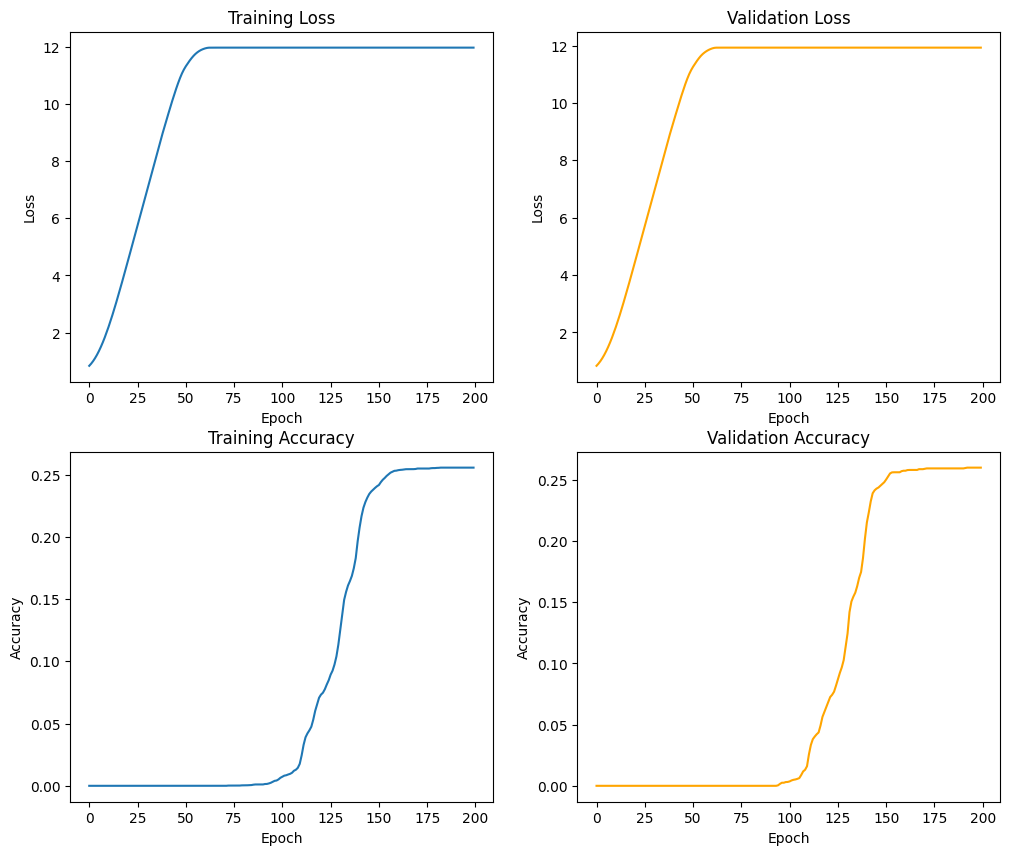

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()